In [1]:
from astropy.nddata import NDDataArray as nda, StdDevUncertainty as sdu
from astropy.table import Table, column
import astropy.units as u
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### First task is sample selection:

In [2]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')
axial_data = Table.read('../fits/Axial_ratios/dr7_isoAB_matched.fits')

In [3]:
morph_data = Table()
morph_data['dr7objid'] = gz2_data['dr7objid']

p_spiral = (gz2_data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']
          * gz2_data['t02_edgeon_a05_no_debiased_rh']
          * gz2_data['t04_spiral_a08_spiral_debiased_rh'])

N_spiral = (gz2_data['t04_spiral_a08_spiral_count'] - 
            gz2_data['t11_arms_number_a37_cant_tell_count'])

p_bar = gz2_data['t03_bar_a06_bar_debiased_rh']

m_columns = ('t11_arms_number_a31_1_debiased_rh',
             't11_arms_number_a32_2_debiased_rh',
             't11_arms_number_a33_3_debiased_rh',
             't11_arms_number_a34_4_debiased_rh',
             't11_arms_number_a36_more_than_4_debiased_rh')

m_array = np.array([gz2_data[c] for c in m_columns]).T
m_absolute = np.argmax(m_array,axis=1) + 1
m_absolute_max = np.max(m_array,axis=1)
m_avg = np.zeros(len(m_array))
for c in range(5):
    m_avg += (c+1) * m_array[:,c]
m_avg /= np.sum(m_array,axis=1)
m_avg[np.isfinite(m_avg) == False] = 0

morph_data['redshift'] = gz2_data['REDSHIFT_1']
morph_data['axial_ratio'] = axial_data['isoB_g'] / axial_data['isoA_g']
morph_data['p_spiral'] = p_spiral
morph_data['N_spiral'] = N_spiral
morph_data['p_bar'] = p_bar
morph_data['m_avg'] = m_avg
morph_data['m'] = m_absolute
morph_data['p_m'] = m_absolute_max
morph_data['p_bar'] = p_bar
morph_data.write('fits/morph_data.fits',overwrite=True)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide


#### Galaxy structure data (mass + size)

In [4]:
from combining_catalogues import match_ids, make_matched_catalogue

simard_data = Table.read('../fits/Simard+Mendel/simard_n4.fits')
mendel_data = Table.read('../fits/Simard+Mendel/mendel_dusty.fits')

In [5]:
ids_ = match_ids(gz2_data,simard_data,'dr7objid','objID')
simard_matched = make_matched_catalogue(gz2_data,simard_data,ids_)
simard_matched['dr7objid'] = gz2_data['dr7objid']
simard_matched.write('../fits/Simard+Mendel/simard_matched.fits',
                     overwrite=True)

ids_ = match_ids(gz2_data,mendel_data,'dr7objid','objID')
mendel_matched = make_matched_catalogue(gz2_data,mendel_data,ids_)
mendel_matched['dr7objid'] = gz2_data['dr7objid']
mendel_matched.write('../fits/Simard+Mendel/mendel_matched.fits',
                     overwrite=True)

248883 galaxies in the reference catalogue
1123718 galaxies in the match catalogue
---> 245259 matches in total
248883 galaxies in the reference catalogue
657996 galaxies in the match catalogue
---> 237996 matches in total


In [7]:
structure_data = Table()
structure_data['dr7objid'] = gz2_data['dr7objid']

def mass_and_error(data,columns):
    mass = 10**data[columns[0]]
    mass_low = 10**data[columns[1]]
    mass_high = 10**data[columns[2]]
    mass_error = np.max([mass-mass_low,mass_high-mass],axis=0)
    #mass_error = (mass_high - mass_low)/2
    mass[(mass <= 0) | (np.isfinite(mass) == False)] = 1
    mass_error[(mass_error <= 0) | (np.isfinite(mass_error) == False)] = 1 
    return mass, mass_error

m_b, m_b_error = mass_and_error(mendel_matched,['logMb','b_logMb','b_logmb_lc'])
m_d,m_d_error = mass_and_error(mendel_matched,['logMd','b_logMd','b_logmd_lc'])
m_total = nda(m_d,sdu(m_d_error)).add(nda(m_b,sdu(m_b_error)))
m_t, m_t_error = m_total.data, m_total.uncertainty.array

# check the fits for reasonable values:
mendel_fit = np.any([mendel_matched['Type'] == 2,
                     mendel_matched['Type'] == 3],axis=0)

simard_fit = np.all([simard_matched['Re'] > 0,
                     simard_matched['Rd'] > 0,
                     np.isfinite(simard_matched['Re']),
                     np.isfinite(simard_matched['Rd'])],axis=0)

fit_ok = np.all([mendel_fit,simard_fit],axis=0)

# Make the table:
R_b, R_b_error = (simard_matched['Re'], simard_matched['e_Re'])
R_d, R_d_error = (simard_matched['Rd'], simard_matched['e_Rd'])

structure_data['m_b'] = m_b * u.Msun
structure_data['delta_m_b'] = m_b_error * u.Msun
structure_data['m_d'] = m_d * u.Msun
structure_data['delta_m_d'] = m_d_error * u.Msun
structure_data['m_t'] = m_t * u.Msun
structure_data['delta_m_t'] = m_t_error * u.Msun#
structure_data['R_b_r'] = R_b / (1+math.sqrt(2)) # Hernquist + half-mass conversion
structure_data['delta_R_b_r'] = R_b_error / (1+math.sqrt(2))
structure_data['R_d_r'] = R_d
structure_data['delta_R_d_r'] = R_d_error
structure_data['Type'] = mendel_matched['Type']
structure_data['fit_ok'] = fit_ok
structure_data['PpS_mendel'] = mendel_matched['PpS']
structure_data['dBD'] = mendel_matched['dBD']

structure_data['R_b'] = structure_data['R_b_r'] #/ 1.5
structure_data['delta_R_b'] = structure_data['delta_R_b_r'] #/ 1.5
structure_data['R_d'] = structure_data['R_d_r'] #/ 1.5
structure_data['delta_R_d'] = structure_data['delta_R_d_r'] #/ 1.5

# modify the mass column for bulge-less galaxies:
disc_only = structure_data['PpS_mendel'] == 2
structure_data['m_b'][disc_only] = 0 * u.Msun

# save the output table
structure_data.write('fits/structure_data.fits',overwrite=True)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less_equal
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less_equal
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in greater


#### HI data

Here, we aim to combine two sets of HI data. The first is ALFALFA, which is available for a subsetof galaxies. For the large fraction of galaxies without ALFALFA, we will use the estimates from Teimoorinia et al. (2016)

In [8]:
a70_data = Table.read('../fits/SF_fits/a70.fits')
teimoorinia_data = Table.read('../fits/ALFALFA/teimoorinia_hi.fits')

In [9]:
# match up the Teimoorinia data to the GZ2 data
from combining_catalogues import match_ids, make_matched_catalogue

matched_ids = match_ids(gz2_data,teimoorinia_data,'dr7objid','ID_SDSS_')
teimoorinia_matched = make_matched_catalogue(gz2_data,teimoorinia_data,matched_ids)
teimoorinia_matched['dr7objid'] = gz2_data['dr7objid']

teimoorinia_matched.write('fits/teimoorinia_matched.fits',overwrite=True)

248883 galaxies in the reference catalogue
561585 galaxies in the match catalogue
---> 225382 matches in total


In [10]:
hi_data = Table()
hi_data['dr7objid'] = gz2_data['dr7objid']

m_hi_t17 = (teimoorinia_matched['_logM_HI/M_*_'] 
          + teimoorinia_matched['_logM_*_'])

hi_data['m_hi_t17'] = 10**m_hi_t17
hi_data['cfgas'] = teimoorinia_matched['_C_fgas_']
#hi_data['delta_m_hi_t17'] = 0.22 * hi_data['m_hi_t17']
hi_data['delta_m_hi_t17'] = 2.303 * hi_data['m_hi_t17'] * 0.22

hi_data['detcode'] = a70_data['detcode']

hi_data['m_hi_a70'] = 10**a70_data['loghimass']
hi_data['delta_m_hi_a70'] = 10**a70_data['loghimass'] / a70_data['snratio']

a70_ok = a70_data['loghimass'] > 0

hi_data['hi_mass'] = hi_data['m_hi_t17']
hi_data['hi_mass_error'] = hi_data['delta_m_hi_t17']

hi_data['hi_mass'][a70_ok] = hi_data['m_hi_a70'][a70_ok]
hi_data['hi_mass_error'][a70_ok] = hi_data['delta_m_hi_a70'][a70_ok]

hi_data.write('fits/hi_data.fits',overwrite=True)

#### Masks table:

Make a table of masks here for the SDSS data.

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in less


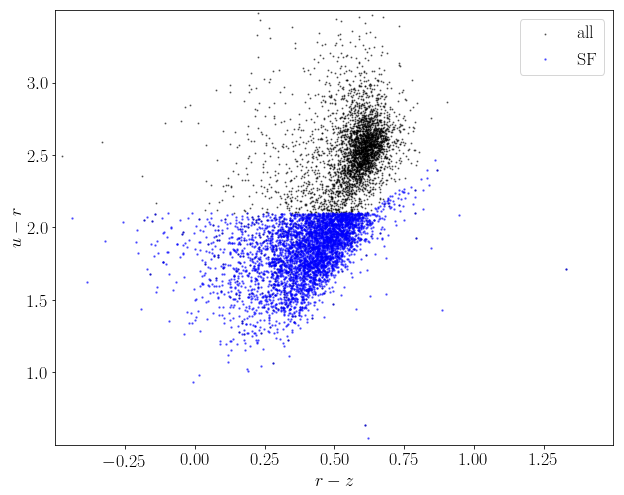

In [11]:
masks = Table()

z_085 = gz2_data['REDSHIFT_1'] <= 0.085
z_055 = gz2_data['REDSHIFT_1'] <= 0.055
has_hi = np.any([hi_data['cfgas'] >= 0.5,
                 hi_data['detcode'] == 1,
                 hi_data['detcode'] == 2],axis=0)

has_mendel = structure_data['fit_ok']

masks['z<0.085'] = np.all([z_085,has_mendel],axis=0)
masks['z<0.055'] = np.all([z_055,has_mendel],axis=0)
masks['z<0.085 (+HI)'] = np.all([z_085,has_mendel,has_hi],axis=0)
masks['z<0.055 (+HI)'] = np.all([z_055,has_mendel,has_hi],axis=0)

# morphological cuts
spiral_ok = np.all([morph_data['p_spiral'] > 0.5,
                    morph_data['N_spiral'] >= 5],axis=0)
unbarred = morph_data['p_bar'] <= 0.2
axial_ok = morph_data['axial_ratio'] >= 0.4

masks['unbarred'] = unbarred
masks['spiral_ok'] = spiral_ok
masks['axial_ok'] = axial_ok

# --- Select star-forming ---
u_r = gz2_data['PETROMAG_MU'] - gz2_data['PETROMAG_MR']
r_z = gz2_data['PETROMAG_MR'] - gz2_data['PETROMAG_MZ']
star_forming = np.any([u_r < 2.1,u_r < 1.6*r_z + 1.1],axis=0)

_ = plt.scatter(r_z[:4000],u_r[:4000],color='k',s=1,alpha=0.5,label='all')
_ = plt.scatter(r_z[star_forming][:4000],u_r[star_forming][:4000],
                color='b',s=2,alpha=0.5,label='SF')
_ = plt.axis((-0.5,1.5,0.5,3.5))
_ = plt.xlabel('$r-z$')
_ = plt.ylabel('$u-r$')
_ = plt.legend()
masks['star_forming'] = star_forming

masks['z<0.085 (unbarred spiral)'] = np.all([z_085,has_mendel,spiral_ok,
                                             axial_ok,unbarred],axis=0)

masks['z<0.085 (+HI unbarred spiral)'] = np.all([z_085,has_mendel,has_hi,
                                      spiral_ok,axial_ok,unbarred],axis=0)

masks.write('fits/masks.fits',overwrite=True)

#### F-test statistics

Here, we will check the F-test, and determine whether one or two components are needed.

In [12]:
# First task: sample selection
mask_columns = ['z<0.085 (+HI)','spiral_ok','axial_ok','unbarred']
sample_ok = np.all([masks[c] for c in mask_columns],axis=0)

B_columns = ['t05_bulge_prominence_a10_no_bulge_debiased_rh',
             't05_bulge_prominence_a11_just_noticeable_debiased_rh',
             't05_bulge_prominence_a12_obvious_debiased_rh',
             't05_bulge_prominence_a13_dominant_debiased_rh']

B_array = np.array([gz2_data[b] for b in B_columns]).T
B_max = np.argmax(B_array,axis=1) + 1
B_sum = np.sum(B_array,axis=1)
B_avg = np.zeros(len(B_array))

weight_values = (0,0.2,0.8,1)
for b, w in enumerate(weight_values):
    B_avg += B_array[:,b] * w
B_avg = B_avg / B_sum

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


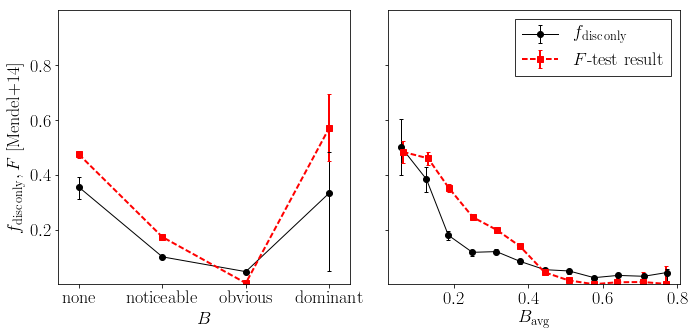

In [13]:
from xy_plots import x_vs_y

fig, axarr = plt.subplots(1,2,figsize=(10,5),sharey=True)

##########################################
ax = axarr[0]

x = B_max[sample_ok]
y = structure_data[sample_ok]['Type'] == 2

xy = x_vs_y(x,y).fraction_with_feature(bin_assignments=x)
xy.error_plot(ax,style='errorbar',label='$f_\mathrm{disc \, only}$',
              marker='o',color='k',lw=1,capsize=2)

y = structure_data['PpS_mendel'][sample_ok]
xy = x_vs_y(x,y).discrete_vs_continuous_binned_median()
xy.error_plot(ax,style='errorbar',label='$F$-test result',
              color='r',marker='s',lw=2,capsize=2,linestyle='dashed')

_ = ax.set_xlabel('$B$')
_ = ax.set_ylabel('$f_\mathrm{disc \, only}, F$ [Mendel+14]')
_ = ax.set_xticks([1,2,3,4])
_ = ax.set_xlim(0.75,4.25)
_ = ax.set_xticklabels(['none','noticeable','obvious','dominant'])
#_ = ax.legend(loc='upper right',fancybox=False,edgecolor='k')
##########################################
ax = axarr[1]

x = B_avg[sample_ok]
y = structure_data[sample_ok]['Type'] == 2

xy = x_vs_y(x,y).fraction_with_feature(bins=12,equal_N=False)
xy.error_plot(ax,style='errorbar',label='$f_\mathrm{disc \, only}$',
              marker='o',color='k',lw=1,capsize=2)

y = structure_data['PpS_mendel'][sample_ok]
xy = x_vs_y(x,y).continuous_vs_continuous_binned_median(bins=12,equal_N=False)
xy.error_plot(ax,style='errorbar',label='$F$-test result',
              color='r',marker='s',lw=2,capsize=2,linestyle='dashed')

_ = ax.set_xlabel('$B_\mathrm{avg}$')
#_ = ax.set_xticks([1,2,3,4])
#_ = ax.set_xlim(0.75,4.25)
_ = ax.set_ylim(0,1)
#_ = ax.set_ylabel('$f_\mathrm{disc \, only}, F$ [Mendel+14]')
_ = ax.legend(loc='upper right',fancybox=False,edgecolor='k')

fig.tight_layout()
fig.savefig('figures/bulge_test.pdf')

#### How do the sample_sizes change varying the overall error?

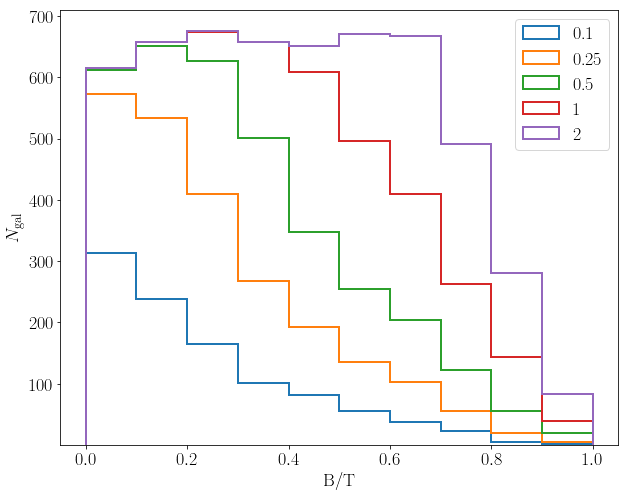

In [14]:
error_limits = [0.1,0.25,0.5,1,2]

bins = np.linspace(0,1,11)

for elim in error_limits:
    mask_lim = np.all([sample_ok,structure_data['dBD'] < elim],axis=0)
    bulge_mass = structure_data['m_b'][mask_lim]
    disc_mass = structure_data['m_d'][mask_lim]
    m_tot = bulge_mass + disc_mass
    btr = bulge_mass / m_tot
    _ = plt.hist(btr,bins,histtype='step',label='{}'.format(elim),lw=2)
    #_ = plt.axvline(np.median(btr))

_ = plt.legend()
_ = plt.xlabel('B/T')
_ = plt.ylabel('$N_\mathrm{gal}$')

In [15]:
from scipy.stats import spearmanr

error_limits = np.arange(0.1,2,0.01)

totalmasses = []
btrs = []
btr_correlations = []
mb_correlations = []
N_gal = []

for elim in error_limits:
    mask_lim = np.all([sample_ok,structure_data['dBD'] < elim],axis=0)
    bulge_mass = structure_data['m_b'][mask_lim]
    disc_mass = structure_data['m_d'][mask_lim]
    m_tot = bulge_mass + disc_mass
    bulge_score = B_avg[mask_lim]
    N_gal.append(mask_lim.sum())
    totalmasses.append(np.median(np.log10(m_tot)))
    btrs.append(np.median(bulge_mass/m_tot))
    btr_correlations.append(spearmanr(bulge_score,bulge_mass/m_tot)[0])
    mb_correlations.append(spearmanr(bulge_score,bulge_mass)[0])

/home/ppxrh/anaconda3/lib/python3.4/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [ ]:
fig, axarr = plt.subplots(5,1,figsize=(10,20))

variables = [N_gal,totalmasses,btrs,btr_correlations,mb_correlations]
ylabels = ('$N_\mathrm{gal}$','$\log(\mathrm{M_*})$','BTR',
           '$r_s(\mathrm{BTR,B_{avg}})$',
           '$r_s(\mathrm{M_B,B_{avg}})$')

for ax, var, ylabel in zip(axarr,variables,ylabels):
    
    _ = ax.plot(error_limits,var,color='k',lw=2)
    _ = ax.set_ylabel(ylabel)

_ = axarr[-1].set_xlabel(r'$\sigma$ (limit)')
_ = fig.subplots_adjust(hspace=0)

best_sigma_btr = np.round(error_limits[np.argmax(btr_correlations)],2)
best_sigma_mb = np.round(error_limits[np.argmax(mb_correlations)],2)

print('sigma best (BTR) = {}'.format(best_sigma_btr))
print('sigma best (M_B) = {}'.format(best_sigma_mb))

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

i = find_nearest(error_limits,0.6)
print('N_gal (sigma < 0.6) = {}'.format(N_gal[i]))